In [8]:
import os
import glob
import spacy
import random
import warnings
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
from collections import Counter
from nltk import ngrams
import pandas as pd
import seaborn as sns

# set the random seed for reproducibility
random.seed(123)
# turn off depreciation warnings and future warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
# function to load data
def load_data(base_dir):
    data = []
    labels = []
    files = []
    for label in ['positive', 'negative']:
        for filepath in glob.glob(os.path.join(base_dir, label, '*.txt')):
            with open(filepath, 'r', encoding='utf-8') as file:
                data.append(file.read())
                labels.append(1 if label == 'positive' else 0)
                files.append(filepath)
                
    return data, labels, files

# delete the contents after "What I've decided and why"
def clean_data(data):
    cleaned_data = []
    for text in data:
        cleaned_data.append(text.split("What I've decided and why")[0])
    return cleaned_data

In [10]:
# load training data
train_data, train_labels, train_files = load_data('data/train')
# load test data
test_data, test_labels, test_files = load_data('data/test')

train_data = clean_data(train_data)
test_data = clean_data(test_data)

# load spacy model
nlp = spacy.load('en_core_web_lg')

# preprocess the texts
def preprocess_texts(texts):
    docs = [nlp(text) for text in texts]
    return docs

# preprocess the training data
train_docs = preprocess_texts(train_data)
# backup the training data for later use
train_docs_backup = train_docs
# preprocess the test data
test_docs = preprocess_texts(test_data)

In [11]:
# function to remove stopwords and punctuation
def remove_stopwords_punctuation(doc):
    # remove stopwords and punctuation
    doc = [token for token in doc if not token.is_stop and not token.is_punct]
    # remove "\n", "Mr", "Mrs", "Miss" and "Ms"
    doc = [token for token in doc if token.text not in ['\n', 'Mr', 'Mrs', 'Miss', 'Ms']]
    # remove single characters
    doc = [token for token in doc if len(token.text) > 1]
    return doc

#  lowercase and lemmatise the tokens
def lowercase_and_lemmatise(docs):
    lemmatised_docs = []
    for doc in docs:
        lemmatised_tokens = [token.lemma_.lower() for token in doc]
        
        lemmatised_docs.append(lemmatised_tokens)
    return lemmatised_docs

# remove stopwords and punctuation from the training data
train_docs = [remove_stopwords_punctuation(doc) for doc in train_docs]
# remove stopwords and punctuation from the test data
test_docs = [remove_stopwords_punctuation(doc) for doc in test_docs]

# lowercase and lemmatise the training data
train_docs = lowercase_and_lemmatise(train_docs)
# lowercase and lemmatise the test data
test_docs = lowercase_and_lemmatise(test_docs)

# split the training data into positive and negative reviews
positive_train_docs = [train_docs[i] for i in range(len(train_docs)) if train_labels[i] == 1]
negative_train_docs = [train_docs[i] for i in range(len(train_docs)) if train_labels[i] == 0]


## Compute the Most Common N-grams

In [12]:
# function to extract n-grams
def extract_ngrams(docs, n):
    ngram_counts = Counter()
    for doc in docs:
        ngram_counts.update(ngrams(doc, n))
    return ngram_counts

# extract n-grams for positive and negative documents
positive_unigrams = extract_ngrams(positive_train_docs, 1)
negative_unigrams = extract_ngrams(negative_train_docs, 1)
positive_bigrams = extract_ngrams(positive_train_docs, 2)
negative_bigrams = extract_ngrams(negative_train_docs, 2)
positive_trigrams = extract_ngrams(positive_train_docs, 3)
negative_trigrams = extract_ngrams(negative_train_docs, 3)
positive_fourgrams = extract_ngrams(positive_train_docs, 4)
negative_fourgrams = extract_ngrams(negative_train_docs, 4)

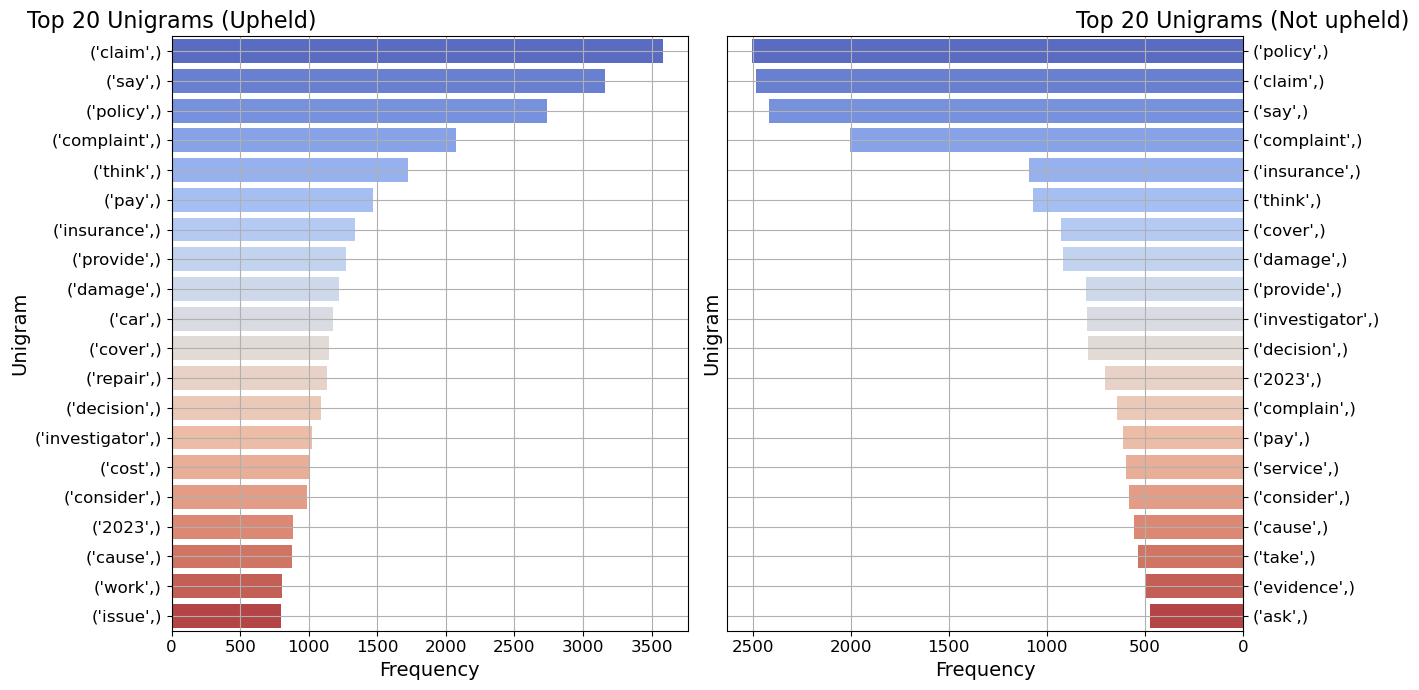

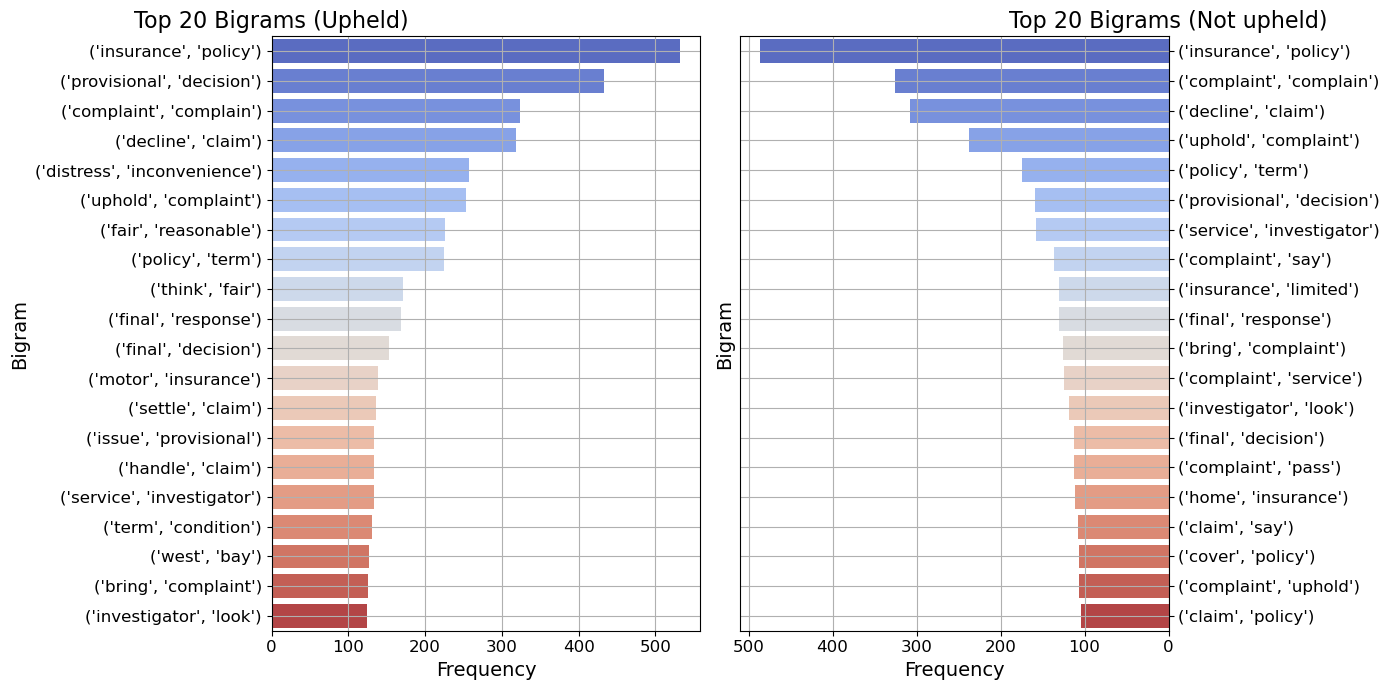

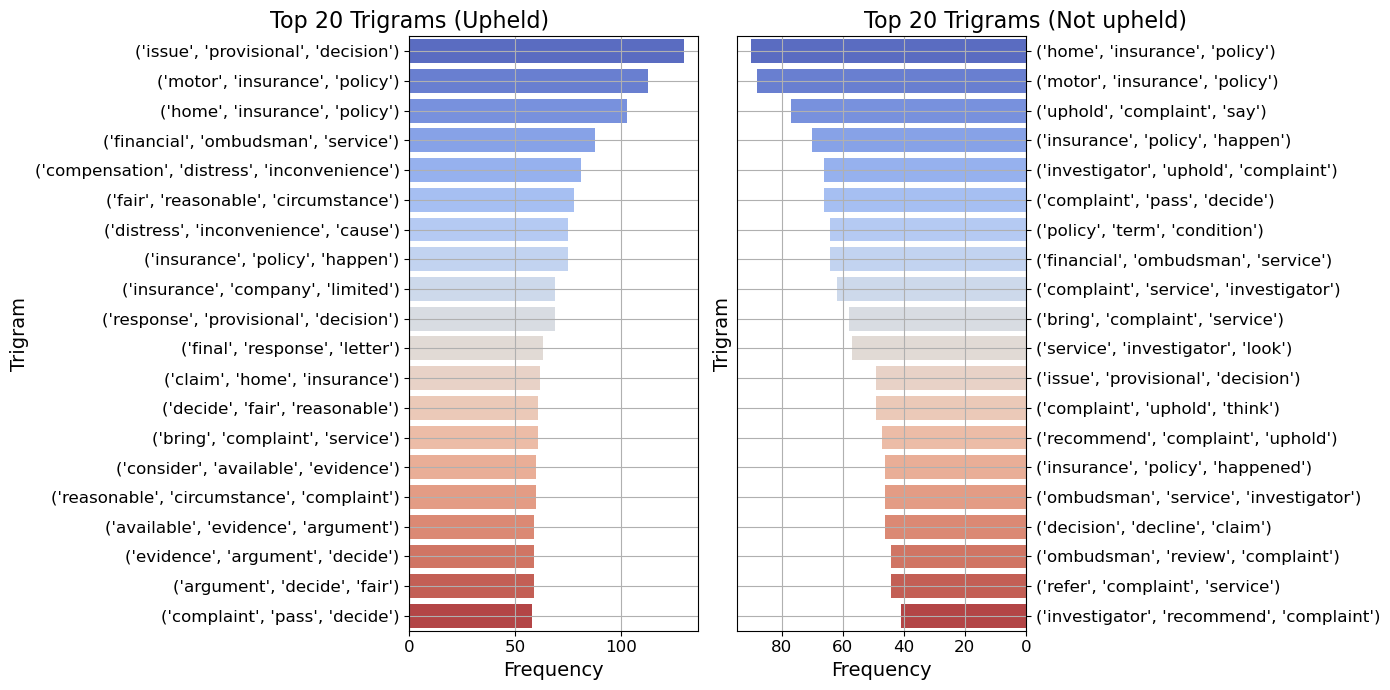

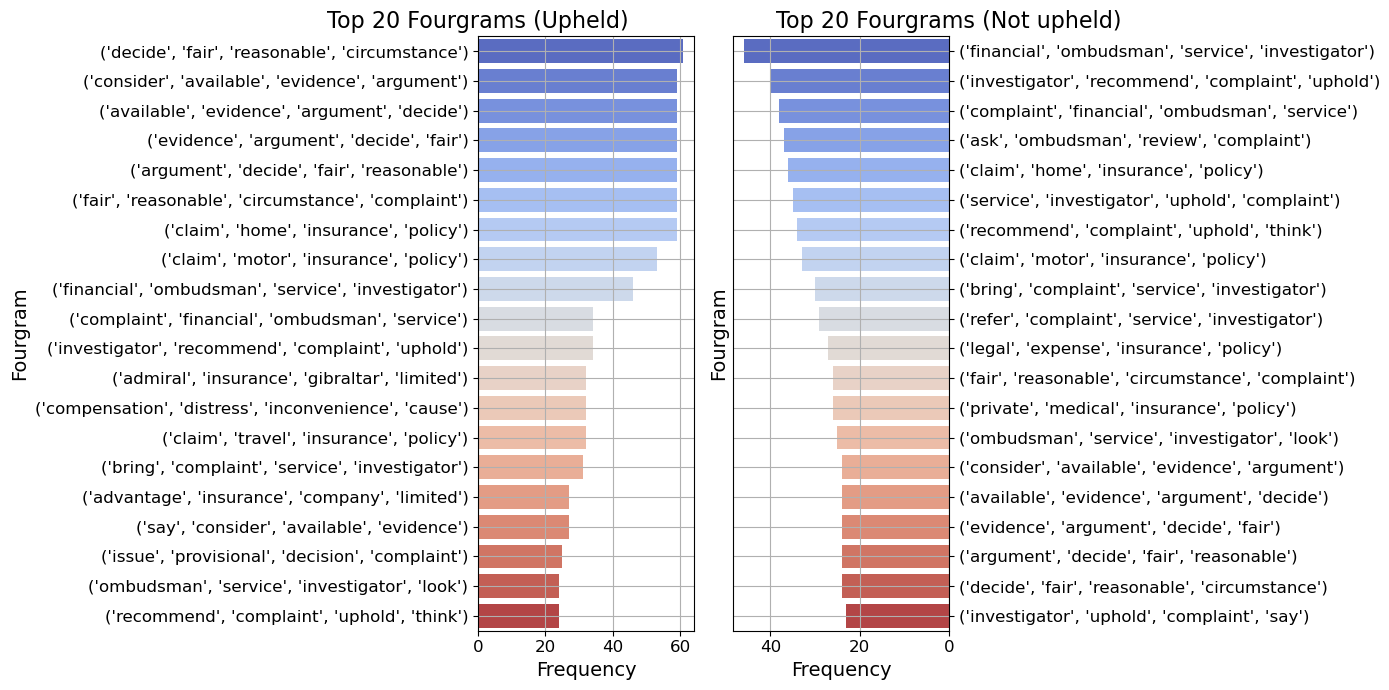

In [67]:

# function to plot n-grams
def plot_ngrams(positive_ngrams, negative_ngrams, ngram_name, num_ngrams=20):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    # positive n-grams
    positive_ngram_df = pd.DataFrame(positive_ngrams.most_common(num_ngrams), columns=[ngram_name, 'Frequency'])
    sns.barplot(x='Frequency', y=ngram_name, data=positive_ngram_df, ax=axs[0], palette='coolwarm')
    axs[0].set_title(f'Top {num_ngrams} {ngram_name}s (Upheld)', fontsize=16)
    axs[0].set_xlabel('Frequency', fontsize=14)
    axs[0].set_ylabel(ngram_name, fontsize=14)
    axs[0].tick_params(axis='both', which='major', labelsize=12)
    axs[0].grid(True)
    axs[0].title.set_position([0, 1])
    
    # negative n-grams
    negative_ngram_df = pd.DataFrame(negative_ngrams.most_common(num_ngrams), columns=[ngram_name, 'Frequency'])
    sns.barplot(x='Frequency', y=ngram_name, data=negative_ngram_df, ax=axs[1], palette='coolwarm')
    axs[1].set_title(f'Top {num_ngrams} {ngram_name}s (Not upheld)', fontsize=16)
    axs[1].set_xlabel('Frequency', fontsize=14)
    axs[1].set_ylabel(ngram_name, fontsize=14)
    axs[1].tick_params(axis='both', which='major', labelsize=12)
    axs[1].grid(True)
    axs[1].invert_xaxis()
    axs[1].yaxis.tick_right() 
    axs[1].title.set_position([1, 1])

    plt.tight_layout()

    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    filename = "eda-" + ngram_name.replace(" ", "-")
    plt.savefig(f'plots/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# plot unigrams
plot_ngrams(positive_unigrams, negative_unigrams, 'Unigram')

# plot bigrams
plot_ngrams(positive_bigrams, negative_bigrams, 'Bigram')

# plot trigrams
plot_ngrams(positive_trigrams, negative_trigrams, 'Trigram')

# plot fourgrams
plot_ngrams(positive_fourgrams, negative_fourgrams, 'Fourgram')

In [23]:
# Name Entity Recognition

# print the labels
print(nlp.get_pipe('ner').labels)
# ('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE',
#  'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT',
#  'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


### Class-wise Distribution

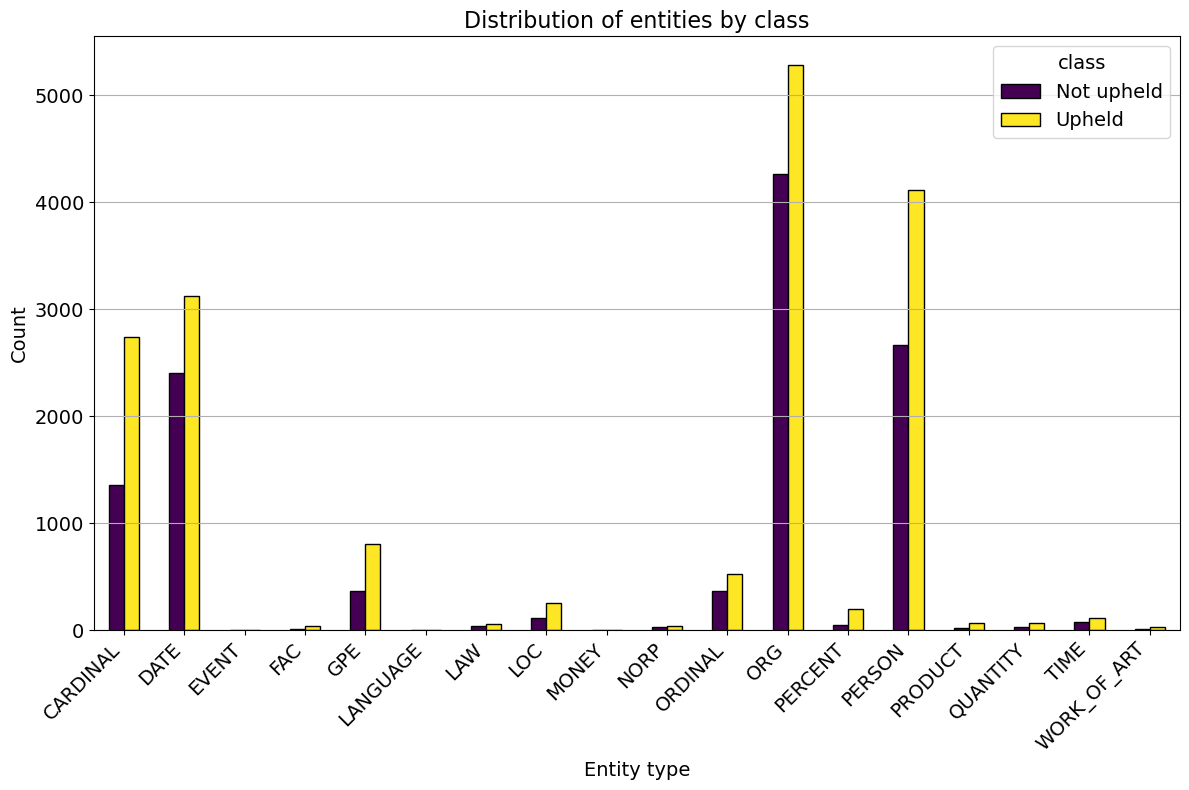

In [68]:

def extract_entities_with_labels(docs, labels):
    entities_with_labels = []
    for doc, label in zip(docs, labels):
        entities_with_labels.extend([(ent.text, ent.label_, label) for ent in doc.ents])
    return entities_with_labels

# Assuming `train_labels_backup` contains the labels for the training documents
entities_with_labels = extract_entities_with_labels(train_docs_backup, train_labels)
entities_with_labels_df = pd.DataFrame(entities_with_labels, columns=['Entity', 'Type', 'Class'])

# Compare entity counts between classes
class_entity_counts = entities_with_labels_df.groupby(['Class', 'Type']).size().unstack(fill_value=0)
# function to plot entity distribution by class
def plot_entity_distribution_by_class(class_entity_counts):
    ax = class_entity_counts.T.plot(kind='bar', stacked=False, figsize=(12, 8), colormap='viridis', edgecolor='black')
    
    plt.xlabel('Entity type', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of entities by class', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title='class', fontsize=14, title_fontsize='14', loc='upper right')
    ax.legend(['Not upheld', 'Upheld'], title='class', fontsize=14, title_fontsize='14', loc='upper right')
    plt.grid(axis='y')
    
    plt.tight_layout()

    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/eda-entity-distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_entity_distribution_by_class(class_entity_counts)

In [53]:
## 

def extract_specific_entity(docs, labels, entity_type):
    entities_with_labels = []
    for doc, label in zip(docs, labels):
        entities_in_doc = [ent.text for ent in doc.ents if ent.label_ == entity_type]
        entities_with_labels.extend([(ent, label) for ent in entities_in_doc])
    return entities_with_labels

# 例如, 我们要分析 `ORG` 实体类型
entity_type = 'ORG'
entities_with_labels = extract_specific_entity(train_docs_backup, train_labels, entity_type)
entities_with_labels_df = pd.DataFrame(entities_with_labels, columns=['Entity', 'Class'])

# 查看数据框架的一部分
print(entities_with_labels_df.head())

# 计算每个分类标签中实体的频率
entity_class_counts = entities_with_labels_df.groupby('Class')['Entity'].count().reset_index()
entity_class_counts.columns = ['Class', 'Count']

# 计算总的文档数量
total_counts = pd.Series(train_labels).value_counts().reset_index()
total_counts.columns = ['Class', 'Total']

# 合并数据框架以计算比例
merged_counts = pd.merge(entity_class_counts, total_counts, on='Class')
merged_counts['Proportion'] = merged_counts['Count'] / merged_counts['Total']

print(merged_counts)

                                   Entity  Class
0  Royal & Sun Alliance Insurance Limited      1
1                                     RSA      1
2                                     RSA      1
3                                     RSA      1
4                                     RSA      1
   Class  Count  Total  Proportion
0      0   4260    412   10.339806
1      1   5284    407   12.982801


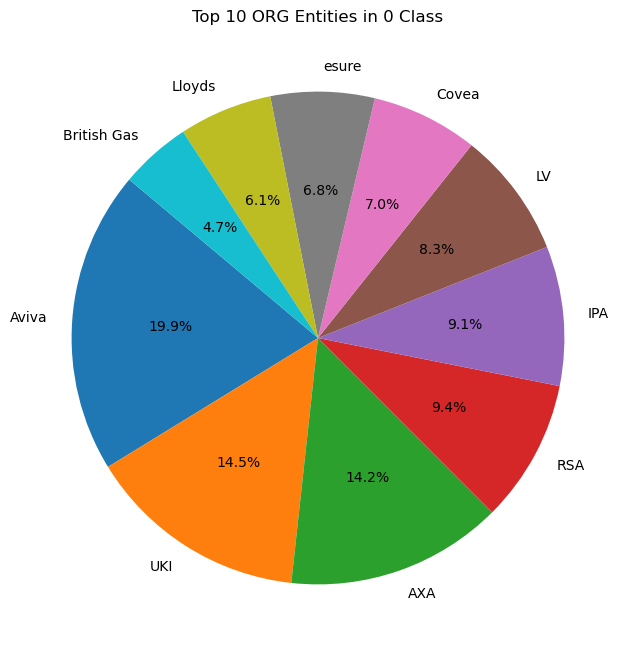

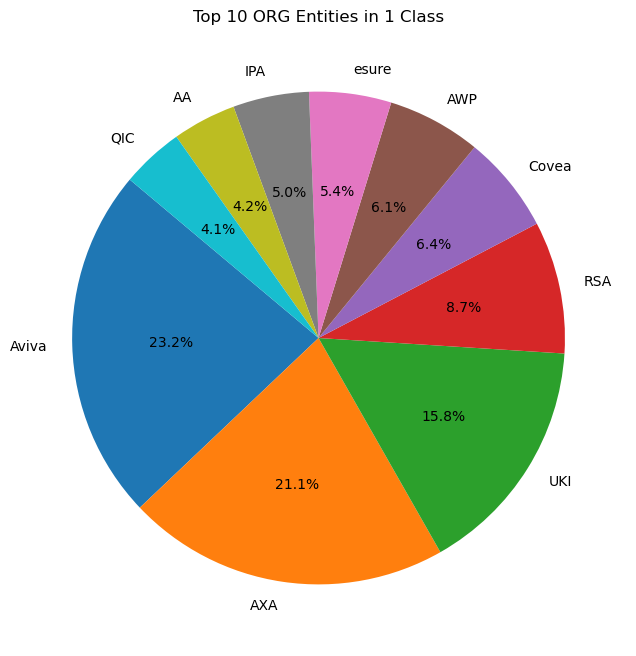

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# 进一步分析，比如绘制饼图
for class_label in merged_counts['Class'].unique():
    class_data = entities_with_labels_df[entities_with_labels_df['Class'] == class_label]
    class_entity_counts = class_data['Entity'].value_counts().nlargest(10)

    plt.figure(figsize=(8, 8))
    plt.pie(class_entity_counts, labels=class_entity_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Top 10 {entity_type} Entities in {class_label} Class')
    plt.show()
